In [1]:
import numpy as np
import tensorflow as tf
from imutils.video import VideoStream
from imutils.video import FPS
import argparse
import imutils
import time
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import UnrealSteel as UR
from mpl_toolkits.mplot3d import axes3d

In [2]:
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

In [3]:
data_mean_2d = np.load('data_mean_2d.npy')
data_std_2d = np.load('data_std_2d.npy')
dim_to_ignore_2d = np.load('dim_to_ignore_2d.npy')
dim_to_use_2d = np.load('dim_to_use_2d.npy')

data_mean_3d = np.load('data_mean_3d.npy')
data_std_3d = np.load('data_std_3d.npy')
dim_to_ignore_3d = np.load('dim_to_ignore_3d.npy')
dim_to_use_3d = np.load('dim_to_use_3d.npy')

In [4]:
#for plot
I_2D  = np.array([1,2,3,1,7,8,1, 13,14,14,18,19,14,26,27])-1 # start points
J_2D  = np.array([2,3,4,7,8,9,13,14,16,18,19,20,26,27,28])-1 # end points
LR_2D = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)

I_3D  = np.array([1,2,3,1,7,8,1, 13,14,15,14,18,19,14,26,27])-1 # start points
J_3D  = np.array([2,3,4,7,8,9,13,14,15,16,18,19,20,26,27,28])-1 # end points
LR_3D = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)

In [5]:
H36M_NAMES = ['']*32
H36M_NAMES[0]  = 'Hip'
H36M_NAMES[1]  = 'RHip'
H36M_NAMES[2]  = 'RKnee'
H36M_NAMES[3]  = 'RFoot'
H36M_NAMES[6]  = 'LHip'
H36M_NAMES[7]  = 'LKnee'
H36M_NAMES[8]  = 'LFoot'
H36M_NAMES[12] = 'Spine'
H36M_NAMES[13] = 'Thorax'
H36M_NAMES[14] = 'Neck/Nose'
H36M_NAMES[15] = 'Head'
H36M_NAMES[17] = 'LShoulder'
H36M_NAMES[18] = 'LElbow'
H36M_NAMES[19] = 'LWrist'
H36M_NAMES[25] = 'RShoulder'
H36M_NAMES[26] = 'RElbow'
H36M_NAMES[27] = 'RWrist'

In [6]:
interpreter = tf.lite.Interpreter(model_path="posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [7]:
UNREALSTEEL = UR.UnrealSteel()
UNREALSTEEL.load_weights('./weights/UR_1')

In [8]:
def img_2d_3d_plot(interpreter, dir, UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d):
    input_shape = input_details[0]['shape']

    im = Image.open(dir)
    im = im.convert('RGB')
    width, height = im.size
    
    im = im.resize((257,257))
    im = np.array([np.array(im, dtype='f')])
    input_data =im/255.0
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()
    
    output_data_1 = interpreter.get_tensor(output_details[0]['index'])
    output_data_2 = interpreter.get_tensor(output_details[1]['index'])
    
    o1 = output_data_1[0]
    score = sigmoid(o1)
    heatmapPosition = []
    for k in range(17):
        temp = []
        for i in range(9):
            for j in range(9):
                temp.append(score[i][j][k])
        temp = np.array(temp)
        max = np.max(temp)
        index = np.where(score == max)
        heatmapPosition.append(index[0][0])
        heatmapPosition.append(index[1][0])
        
    heatmapPosition = np.array(heatmapPosition).reshape((17,2))
    
    o2 = output_data_2[0]
    OV = []
    for i,heat in enumerate(heatmapPosition):
        OV.append(o2[heat[0]][heat[1]][i])
        OV.append(o2[heat[0]][heat[1]][i+17])
    Offset_vec = np.array(OV)
    Offset_vec = Offset_vec.reshape((17,2))
    
    KeyPoint = heatmapPosition*32
    RKeyPoint = KeyPoint + Offset_vec
    
    xcoord = []
    ycoord = []
    
    for i in range(17):
        ycoord.append(RKeyPoint[i][0])
        xcoord.append(RKeyPoint[i][1])
    
    for x in range(17):
        xcoord[x] = xcoord[x]*width/257
        ycoord[x] = ycoord[x]*height/257
    #xcoord, ycoord for plot
        
    #16개 2D -> I/P 순서
    #12+11, 12, 14, 16, 11, 13, 15, 6+5, 0+(6+5), 
    #0, 5, 7, 9, 6, 8, 10 
    order_1 = [12, 14, 16, 11, 13, 15]
    order_2 = [0, 5, 7, 9, 6, 8, 10]
    my_s = []

    my_s.append((xcoord[12]+xcoord[11])/2)
    my_s.append((ycoord[12]+ycoord[11])/2)

    for o in order_1:
        my_s.append(xcoord[o])
        my_s.append(ycoord[o])
    
    chest_x = (xcoord[6]+xcoord[5])/2   
    chest_y = (ycoord[6]+ycoord[5])/2
    my_s.append(chest_x)
    my_s.append(chest_y)

        
    neck_x = (chest_x + xcoord[0])/2
    neck_y = (chest_y + ycoord[0])/2
    my_s.append(neck_x)
    my_s.append(neck_y)
    
    for o in order_2:
        my_s.append(xcoord[o])
        my_s.append(ycoord[o])
        
    my_s_enc_in = np.array(my_s)
    mean_2d = data_mean_2d[dim_to_use_2d]
    std_2d = data_std_2d[dim_to_use_2d]
    
    data_in = np.divide((my_s_enc_in-mean_2d), std_2d)
    
    # input to model
    data_out = UNREALSTEEL(np.array([data_in]))
    data_out_a = UR.unNormalizeData(np.array([data_out]),data_mean_3d, data_std_3d, dim_to_ignore_3d)
    data_out_b = np.reshape( data_out_a[0], (len(H36M_NAMES), -1)) 
    
    # img, result plotting code
    
    cv_im = cv2.imread(dir, cv2.IMREAD_COLOR)
    b, g, r = cv2.split(cv_im)
    cv_im = cv2.merge([r,g,b])
    frame =cv2.merge([r,g,b])
    for i in range(0,5):
        cv2.circle(frame,(int(round(xcoord[i])),int(round(ycoord[i]))), 4, (255,0,0), -1)

    #body plot(line)
    #arm1
    cv2.line(frame, (int(round(xcoord[6])), int(round(ycoord[6]))), (int(round(xcoord[8])), int(round(ycoord[8]))), (0,0, 255), 4)
    cv2.line(frame, (int(round(xcoord[8])), int(round(ycoord[8]))), (int(round(xcoord[10])), int(round(ycoord[10]))), (0,0, 255), 4)
    #arm2
    cv2.line(frame, (int(round(xcoord[5])), int(round(ycoord[5]))), (int(round(xcoord[7])), int(round(ycoord[7]))), (0, 255,0), 4)
    cv2.line(frame, (int(round(xcoord[7])), int(round(ycoord[7]))), (int(round(xcoord[9])), int(round(ycoord[9]))), (0, 255,0), 4)
    #torso
    cv2.line(frame, (int(round(xcoord[5])), int(round(ycoord[5]))), (int(round(xcoord[6])), int(round(ycoord[6]))), (130,30, 75), 4)
    cv2.line(frame, (int(round(xcoord[5])), int(round(ycoord[5]))), (int(round(xcoord[11])), int(round(ycoord[11]))), (130,30, 75), 4)
    cv2.line(frame, (int(round(xcoord[6])), int(round(ycoord[6]))), (int(round(xcoord[12])), int(round(ycoord[12]))), (130,30, 75), 4)
    cv2.line(frame, (int(round(xcoord[11])), int(round(ycoord[11]))), (int(round(xcoord[12])), int(round(ycoord[12]))), (130,30, 75), 4)
    #leg1
    cv2.line(frame, (int(round(xcoord[12])), int(round(ycoord[12]))), (int(round(xcoord[14])), int(round(ycoord[14]))), (0,0, 255), 4)
    cv2.line(frame, (int(round(xcoord[14])), int(round(ycoord[14]))), (int(round(xcoord[16])), int(round(ycoord[16]))), (0,0, 255), 4)
    #leg2
    cv2.line(frame, (int(round(xcoord[11])), int(round(ycoord[11]))), (int(round(xcoord[13])), int(round(ycoord[13]))), (0, 255,0), 4)
    cv2.line(frame, (int(round(xcoord[13])), int(round(ycoord[13]))), (int(round(xcoord[15])), int(round(ycoord[15]))), (0,255, 0), 4)
    
    
    
    
    fig = plt.figure( figsize = (16,12))
    
    ax1 = plt.subplot(2,2,1)
    ax1.set_title("Original Data")
    ax1.imshow(cv_im)
    
    ax2 = plt.subplot(2,2,2)
    ax2.set_title("2D Joint detection")
    ax2.imshow(frame)
    '''
    ax3 = plt.subplot(2,3,3)
    ax3.plot(xcoord,ycoord, 'bo')
    ax3.invert_yaxis()
    ax3.set_aspect('equal')
    '''
    #=====================================================================================================
    
    #===============================================================================================================
    x_sample = UR.unNormalizeData(np.array([data_in]), data_mean_2d, data_std_2d, dim_to_ignore_2d)
    x_sample = np.reshape( x_sample[0], (len(H36M_NAMES), -1))
    
    ax4 = plt.subplot(2,2,3)
    for i in np.arange( len(I_2D) ):
      x, y = [np.array( [x_sample[I_2D[i], j], x_sample[J_2D[i], j]] ) for j in range(2)]
      ax4.plot(x, y, lw=2, c='b' if LR_2D[i] else 'g')
    ax4.set_title("2D")

    RADIUS = 350 # space around the subject
    xroot, yroot = x_sample[0,0], x_sample[0,1]
    ax4.set_xlim([-width/2-10+xroot, width/2+10+xroot])
    ax4.set_ylim([-height/2-10+yroot, height/2+10+yroot])
    #ax1.set_ylim([-2,1])
    ax4.invert_yaxis()

    ax4.set_aspect('equal')

    #3D Predictioin===========================================================================================================================
    ax6 = plt.subplot(2,2,4, projection = '3d')
    for i in np.arange( len(I_3D) ):
      x, y, z = [np.array( [data_out_b[I_3D[i], j], data_out_b[J_3D[i], j]] ) for j in range(3)]
      ax6.plot(x*0.78 + z*0.64 , x*0.64-z*0.76, -y, lw=2, c='b' if LR_3D[i] else 'g')
    #sin20 = 0.3 cos20 = 0.86
    RADIUS = 750 # space around the subject
    xroot, yroot, zroot = data_out_b[0,0], data_out_b[0,1], data_out_b[0,2]
    ax6.set_xlim3d([-RADIUS+xroot, RADIUS+xroot])
    ax6.set_zlim3d([-RADIUS+zroot, RADIUS+zroot])
    ax6.set_ylim3d([-RADIUS+yroot, RADIUS+yroot])


    #ax6.set_xlabel("x")
    #ax6.set_ylabel("y")
    #ax6.set_zlabel("z")
    ax6.set_title("3D Prediction")
    
    # Get rid of the panes (actually, make them white)
    white = (1.0, 1.0, 1.0, 0.0)
    ax6.w_xaxis.set_pane_color(white)
    ax6.w_yaxis.set_pane_color(white)
    # Keep z pane

    # Get rid of the lines in 3d
    ax6.w_xaxis.line.set_color(white)
    ax6.w_yaxis.line.set_color(white)
    ax6.w_zaxis.line.set_color(white)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



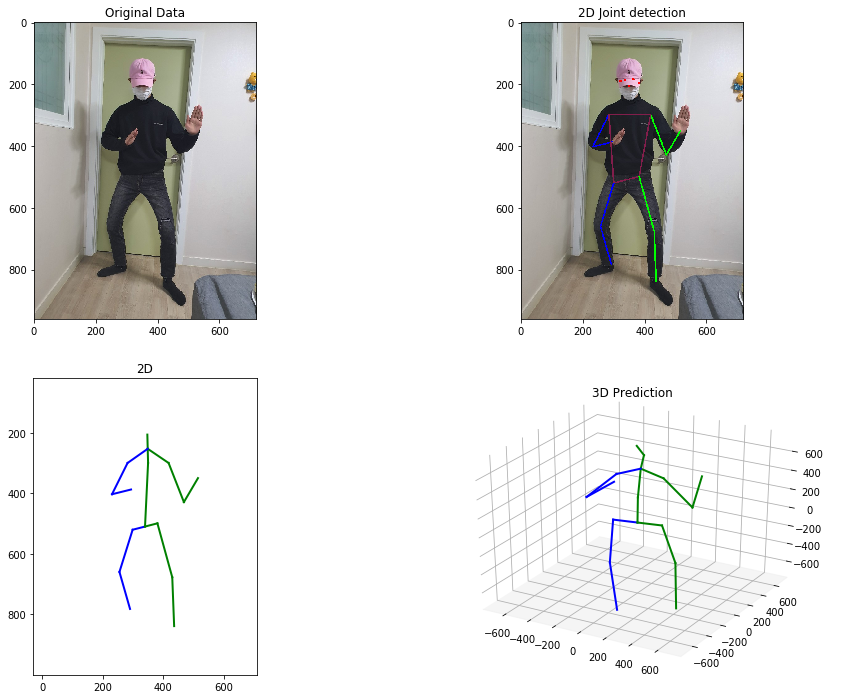

In [9]:
img_2d_3d_plot(interpreter, 'sample_6.jpg', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

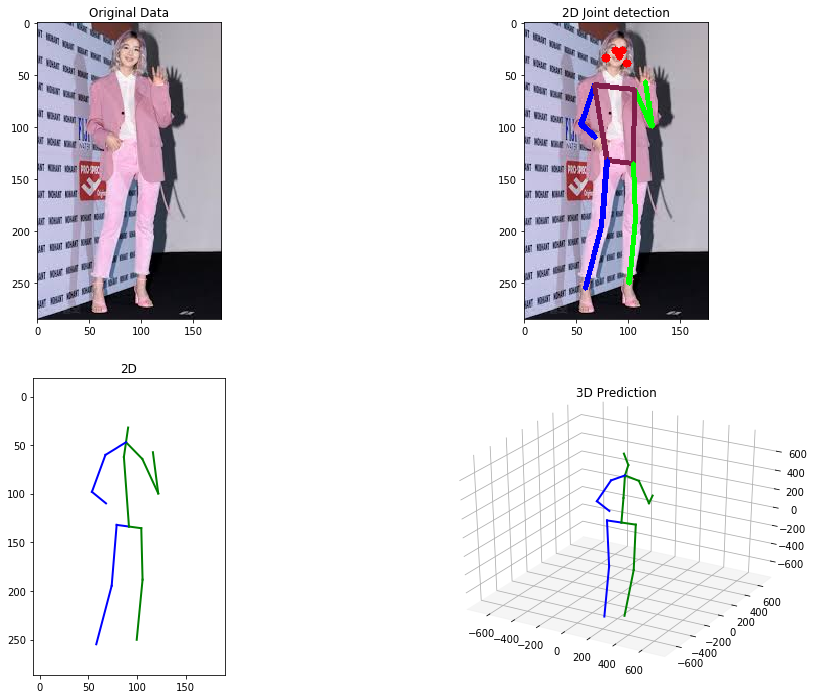

In [10]:
img_2d_3d_plot(interpreter, 'Hi.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

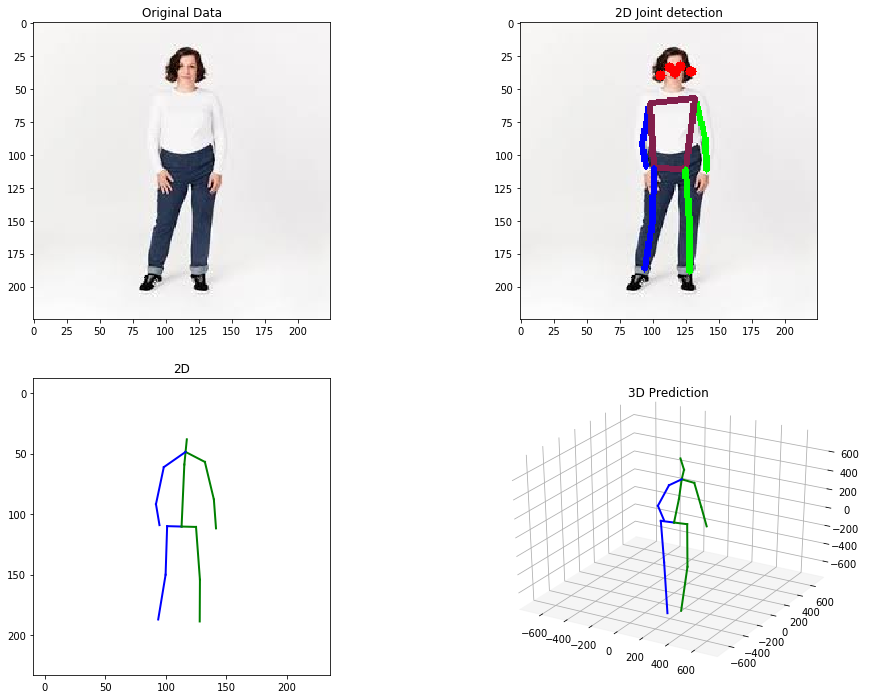

In [11]:
img_2d_3d_plot(interpreter, 'standing.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

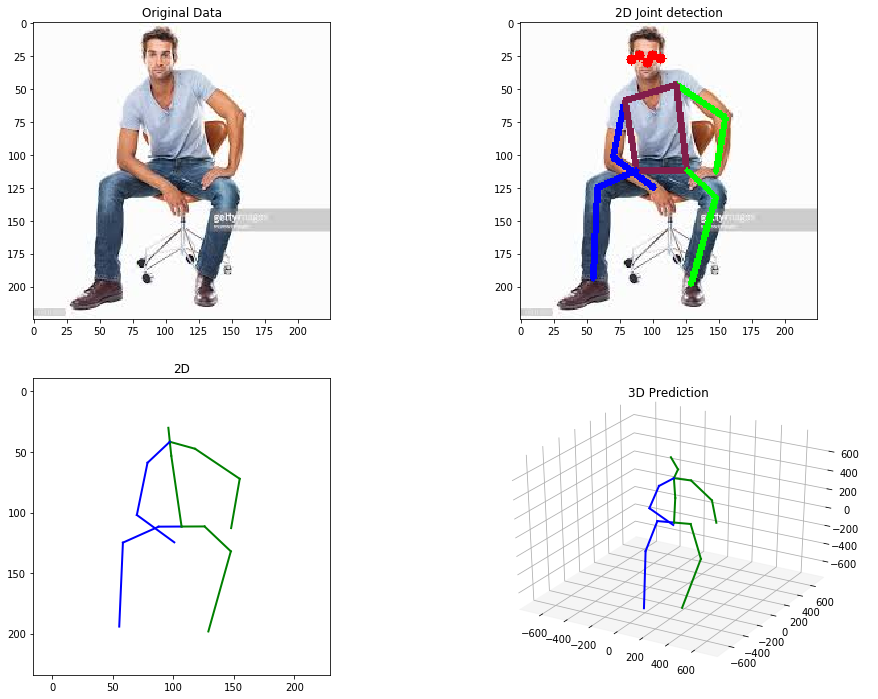

In [12]:
img_2d_3d_plot(interpreter, 'sit.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

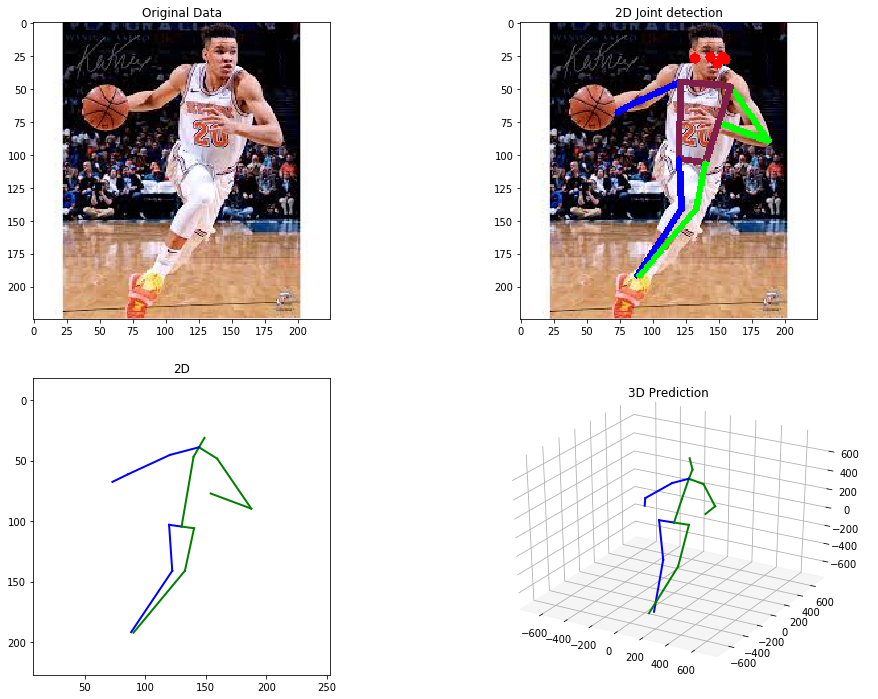

In [13]:
img_2d_3d_plot(interpreter, 'drib.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

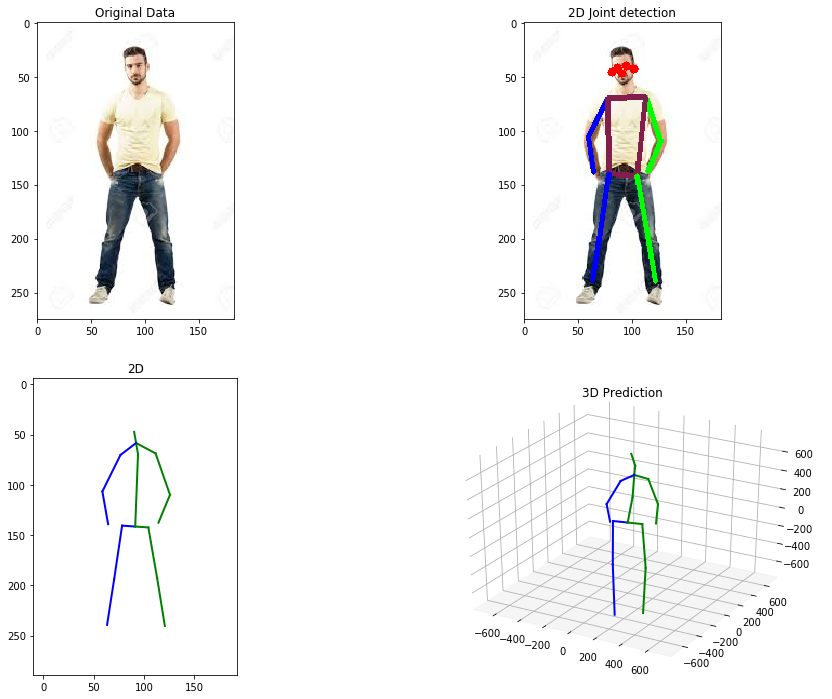

In [14]:
img_2d_3d_plot(interpreter, 'pose.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

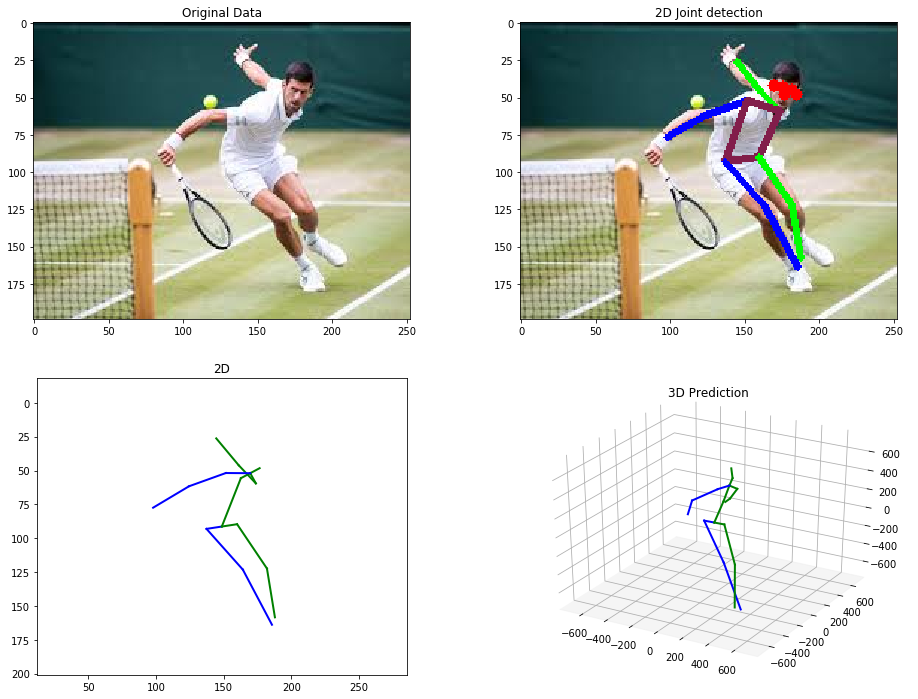

In [15]:
img_2d_3d_plot(interpreter, 'tennis.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

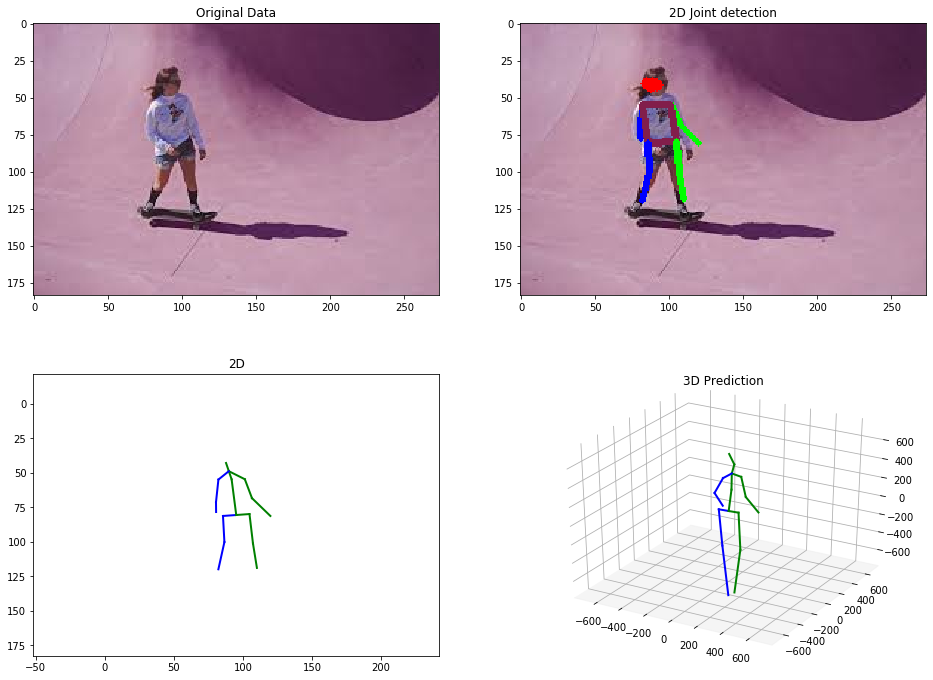

In [16]:
img_2d_3d_plot(interpreter, 'board.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

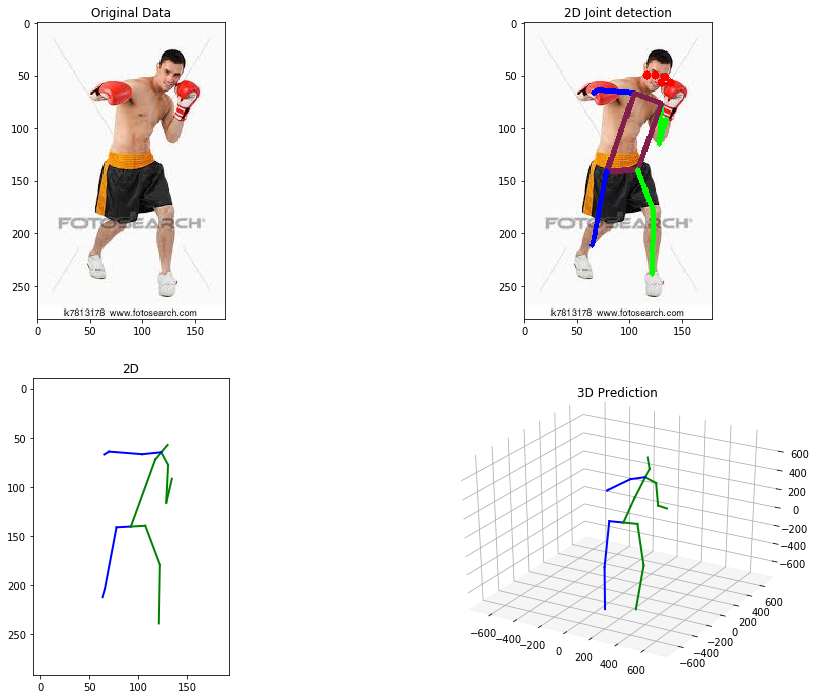

In [17]:
img_2d_3d_plot(interpreter, 'punch.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

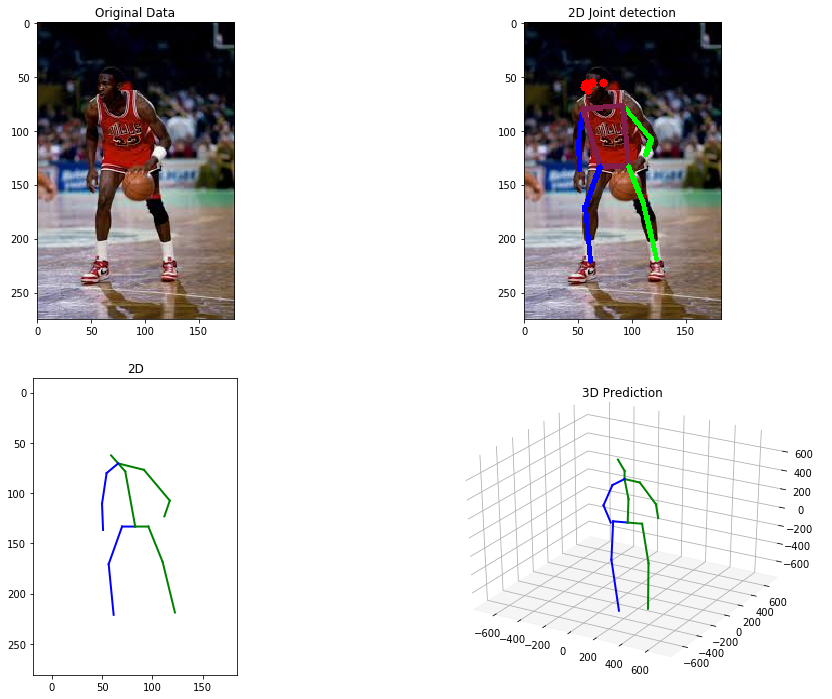

In [18]:
img_2d_3d_plot(interpreter, 'jordan.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

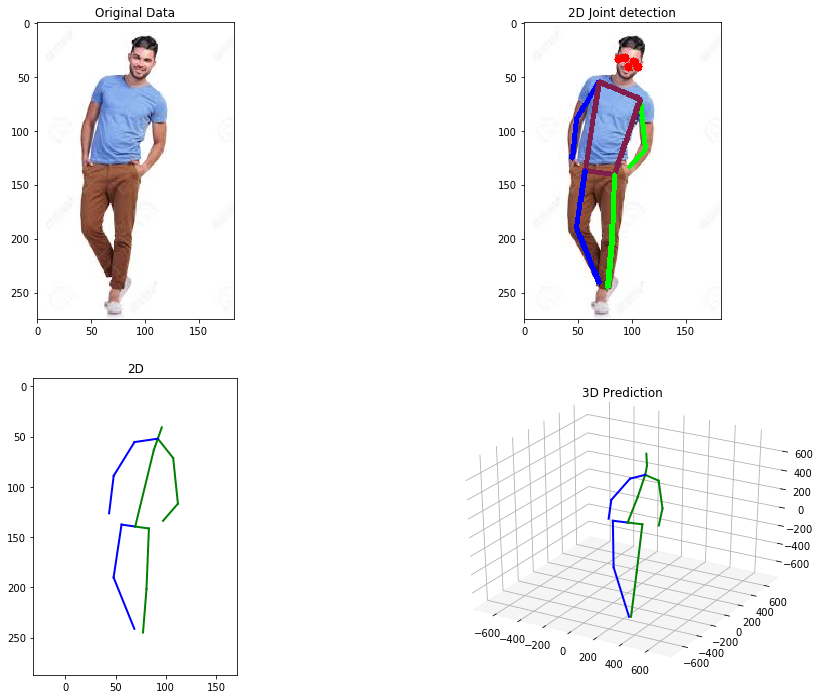

In [19]:
img_2d_3d_plot(interpreter, 'full body.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

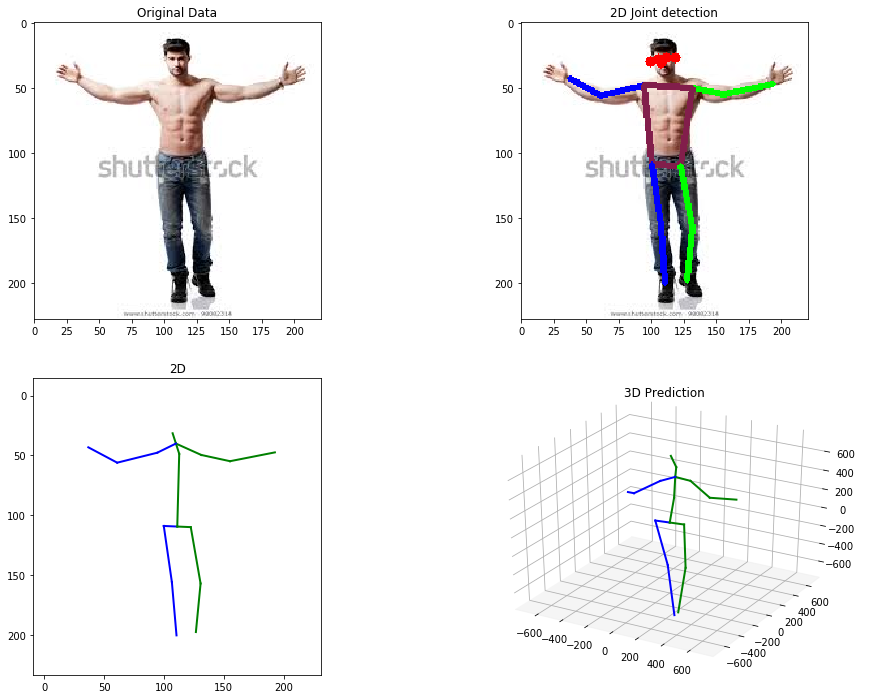

In [20]:
img_2d_3d_plot(interpreter, 'muscle.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

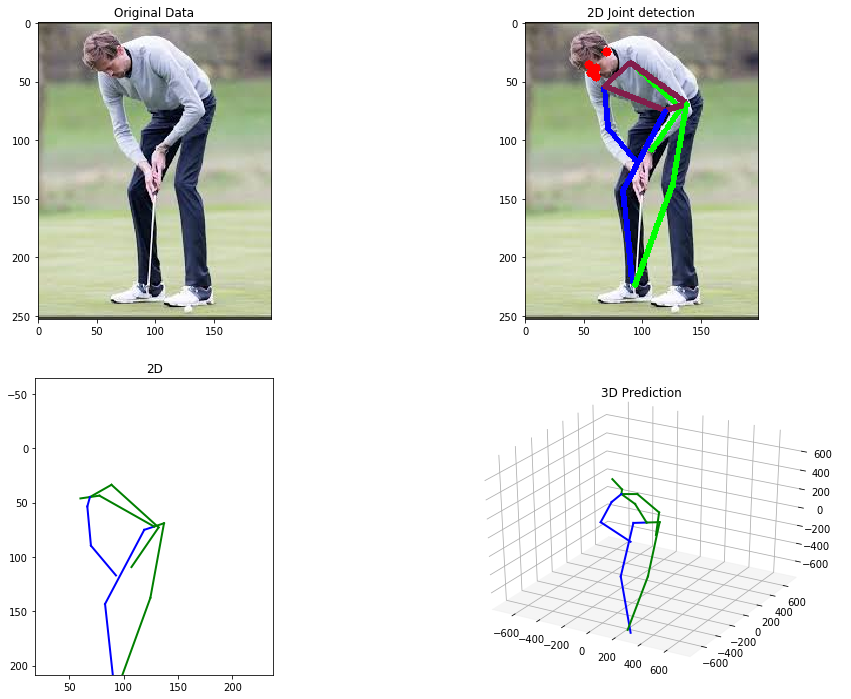

In [21]:
img_2d_3d_plot(interpreter, 'crouch.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)

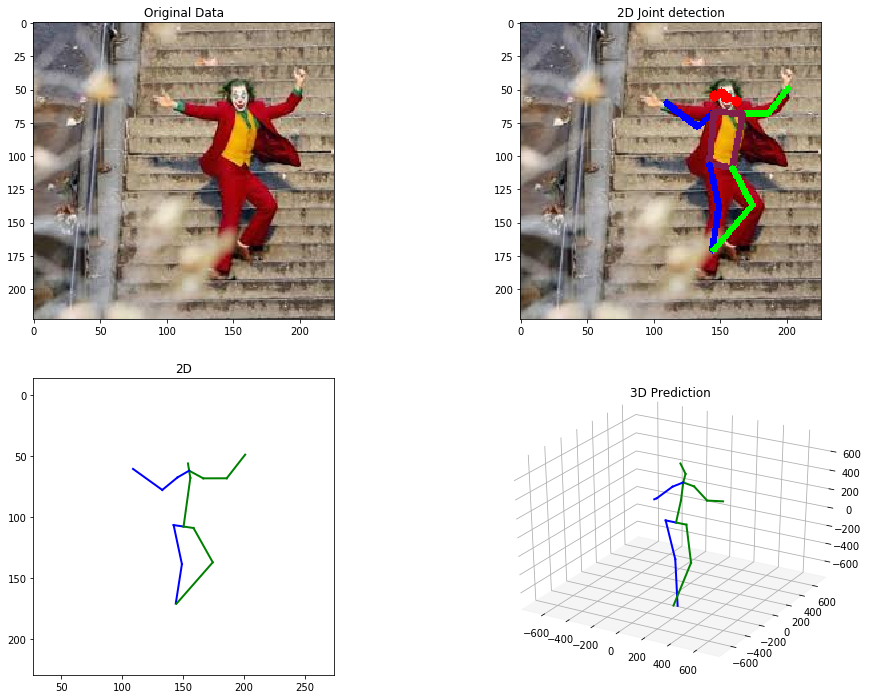

In [22]:
img_2d_3d_plot(interpreter, 'joker.jfif', UNREALSTEEL, data_mean_2d, data_std_2d, dim_to_ignore_2d, dim_to_use_2d, data_mean_3d, data_std_3d, dim_to_ignore_3d, dim_to_use_3d)